# Financial Analysis & LTV Prediction for AtliQ Hardware

In this project, I work as a **data analyst** for a consulting agency, helping a major hardware supplier — **AtliQ Hardware** — analyze and optimize its sales performance.

## Goal
The main objective is to perform **financial analysis**.

## What I Did
- Audited financial metrics such as revenue, profit, and discount structures.
- Conducted customer and product profitability analysis.
- Identified regional and seasonal sales patterns.
- Built an **LTV prediction model** using real business data.

## Project Dashboard Presentation

You can view the interactive Tableau dashboard for this project here:  
[View Finance Dashboard on Tableau Public](https://public.tableau.com/shared/DRHWBG8CH?:display_count=n&:origin=viz_share_link)


> This project reflects real-world consulting tasks in the FinTech and eCommerce domains, where data-driven decision-making leads to stronger customer relationships and increased profitability.creased profitability.

## Part 1: Data Preparation & Cleaning
- Loading the SQLite database, converting data types, handling missing values, and preparing the dataset for analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression

## Entity Relationship Diagram (ERD)

The following diagram represents the structure of the AtliQ Hardware database.

![ERD](erd.jpg)

### Key Insights from the Schema:

- `fact_sales_monthly` is the central table, capturing monthly sales transactions including product, customer, quantity, and date.
- It connects to:
  - `dim_product` — to enrich each sale with product details (e.g., category, segment).
  - `dim_customer` — to associate each sale with customer and regional information.
  - `fact_gross_price` — to retrieve the unit selling price for each product.
  - `fact_manufacturing_cost` — to determine the cost of producing each unit sold.
  - `fact_pre_discount` — to apply pre-invoice discount percentages based on customer and year.

This ERD helps us understand how to join the tables effectively in SQL queries to calculate key financial metrics such as:
- **Revenue** = `sold_quantity * gross_price`
- **Cost of Goods Sold (COGS)** = `sold_quantity * manufacturing_cost`
- **Discounts** = `revenue * pre_invoice_discount_pct`
- **Profit** = `revenue - discount - COGS`

We'll use this structure to build queries, calculate financial KPIs, and analyze performance by customer, product, region, and time.


## Table 1: dim_customer -contains customer-related data

In [2]:
### connect to the database
import sqlite3
con = sqlite3.connect('atliq_db.sqlite3') #-->specify the path to your 
#downloaded database just like you read csv files

### check all tables in the database
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

### execute simple query in Python with your connection
query="""Select * from 
dim_customer
"""
dim_customer=pd.read_sql_query(query, con)
dim_customer.head()

[('dim_customer',), ('dim_product',), ('fact_pre_discount',), ('fact_manufacturing_cost',), ('fact_gross_price',), ('fact_sales_monthly',)]


,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC


In [3]:
def check_dataframe(dataframe):
    print("Data info:")
    print(dataframe.info())
    print("\n nulls:")
    print(dataframe.isnull().sum())
    print("\n Duplicates:", dataframe.duplicated().sum())

In [4]:
check_dataframe(dim_customer)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_code  209 non-null    int64 
 1   customer       209 non-null    object
 2   platform       209 non-null    object
 3   channel        209 non-null    object
 4   market         209 non-null    object
 5   sub_zone       209 non-null    object
 6   region         209 non-null    object
dtypes: int64(1), object(6)
memory usage: 11.6+ KB
None

 nulls:
customer_code    0
customer         0
platform         0
channel          0
market           0
sub_zone         0
region           0
dtype: int64

 Duplicates: 0


In [5]:
dim_customer['channel'] = dim_customer['channel'].astype('category')
dim_customer['platform'] = dim_customer['platform'].astype('category')
dim_customer['market'] = dim_customer['market'].astype('category')
dim_customer['sub_zone'] = dim_customer['sub_zone'].astype('category')
dim_customer['region'] = dim_customer['region'].astype('category')

In [6]:
dim_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customer_code  209 non-null    int64   
 1   customer       209 non-null    object  
 2   platform       209 non-null    category
 3   channel        209 non-null    category
 4   market         209 non-null    category
 5   sub_zone       209 non-null    category
 6   region         209 non-null    category
dtypes: category(5), int64(1), object(1)
memory usage: 6.5+ KB


To improve performance and optimize memory usage, I converted several categorical columns in the dim_customer table from object to category type. As a result, the memory usage was reduced from 11.6 KB to 6.5 KB, and further operations like filtering, grouping, and joining will now be more efficient.

## Table 2: dim_product  -contains product-related data


In [7]:
### execute simple query in Python with your connection
query="""Select * from 
dim_product
"""
dim_product=pd.read_sql_query(query, con)
dim_product.head()

,product_code,division,segment,category,product,variant
0,A0118150101,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
1,A0118150102,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Plus
2,A0118150103,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium
3,A0118150104,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium Plus
4,A0219150201,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard


In [8]:
check_dataframe(dim_product)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_code  397 non-null    object
 1   division      397 non-null    object
 2   segment       397 non-null    object
 3   category      397 non-null    object
 4   product       397 non-null    object
 5   variant       397 non-null    object
dtypes: object(6)
memory usage: 18.7+ KB
None

 nulls:
product_code    0
division        0
segment         0
category        0
product         0
variant         0
dtype: int64

 Duplicates: 0


In [9]:
dim_product['division'] = dim_product['division'].astype('category')
dim_product['segment'] = dim_product['segment'].astype('category')
dim_product['category'] = dim_product['category'].astype('category')
dim_product['variant'] = dim_product['variant'].astype('category')

In [10]:
dim_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   product_code  397 non-null    object  
 1   division      397 non-null    category
 2   segment       397 non-null    category
 3   category      397 non-null    category
 4   product       397 non-null    object  
 5   variant       397 non-null    category
dtypes: category(4), object(2)
memory usage: 10.1+ KB


To optimize memory usage and improve efficiency during data analysis, I converted several columns in the dim_product table from object to category type.After the conversion, memory usage dropped from 18.7 KB to 10.1 KB, almost a 46% reduction.

## Table 3: fact_gross_price -contains gross price information for each product

In [11]:
### execute simple query in Python with your connection
query="""Select * from 
fact_gross_price
"""
fact_gross_price=pd.read_sql_query(query, con)
fact_gross_price.head()

,product_code,fiscal_year,gross_price
0,A0118150101,2018,15.3952
1,A0118150101,2019,14.4392
2,A0118150101,2020,16.2323
3,A0118150101,2021,19.0573
4,A0118150102,2018,19.5875


In [12]:
check_dataframe(fact_gross_price) 

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_code  1182 non-null   object 
 1   fiscal_year   1182 non-null   int64  
 2   gross_price   1182 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 27.8+ KB
None

 nulls:
product_code    0
fiscal_year     0
gross_price     0
dtype: int64

 Duplicates: 0


## Table 4: fact_manufacturing_cost -contains the cost incurred in the production of each product


In [13]:
### execute simple query in Python with your connection
query="""Select * from 
fact_manufacturing_cost
"""
fact_manufacturing_cost=pd.read_sql_query(query, con)
fact_manufacturing_cost.head()

,product_code,cost_year,manufacturing_cost
0,A0118150101,2018,4.6190
1,A0118150101,2019,4.2033
2,A0118150101,2020,5.0207
3,A0118150101,2021,5.5172
4,A0118150102,2018,5.6036


In [14]:
check_dataframe(fact_manufacturing_cost) 

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_code        1182 non-null   object 
 1   cost_year           1182 non-null   int64  
 2   manufacturing_cost  1182 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 27.8+ KB
None

 nulls:
product_code          0
cost_year             0
manufacturing_cost    0
dtype: int64

 Duplicates: 0


In [15]:
fact_manufacturing_cost['manufacturing_cost'].describe()

count    1182.000000
mean       63.000676
std        74.015524
min         0.865400
25%         5.419250
50%        11.417600
75%       122.560350
max       263.420700
Name: manufacturing_cost, dtype: float64

## Table 5: fact_pre_discount -contains pre-invoice deductions information for each product

In [16]:
### execute simple query in Python with your connection
query="""Select * from 
fact_pre_discount
"""
fact_pre_discount=pd.read_sql_query(query, con)
fact_pre_discount.head()

,customer_code,fiscal_year,pre_invoice_discount_pct
0,70002017,2018,0.0824
1,70002017,2019,0.0777
2,70002017,2020,0.0735
3,70002017,2021,0.0703
4,70002017,2022,0.1057


In [17]:
check_dataframe(fact_pre_discount)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_code             1045 non-null   int64  
 1   fiscal_year               1045 non-null   int64  
 2   pre_invoice_discount_pct  1045 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 24.6 KB
None

 nulls:
customer_code               0
fiscal_year                 0
pre_invoice_discount_pct    0
dtype: int64

 Duplicates: 0


## Table 6: fact_sales_monthly  -contains monthly sales data for each product.

In [18]:
### execute simple query in Python with your connection
query="""Select * from 
fact_sales_monthly
"""
fact_sales_monthly=pd.read_sql_query(query, con)
fact_sales_monthly.head()

,date,product_code,customer_code,sold_quantity,fiscal_year
0,2017-09-01,A0118150101,70002017.0,51.0,2018.0
1,2017-09-01,A0118150101,70002018.0,77.0,2018.0
2,2017-09-01,A0118150101,70003181.0,17.0,2018.0
3,2017-09-01,A0118150101,70003182.0,6.0,2018.0
4,2017-09-01,A0118150101,70006157.0,5.0,2018.0


In [19]:
check_dataframe(fact_sales_monthly) 

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67251 entries, 0 to 67250
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           67251 non-null  object 
 1   product_code   67251 non-null  object 
 2   customer_code  67250 non-null  float64
 3   sold_quantity  67250 non-null  float64
 4   fiscal_year    67250 non-null  float64
dtypes: float64(3), object(2)
memory usage: 2.6+ MB
None

 nulls:
date             0
product_code     0
customer_code    1
sold_quantity    1
fiscal_year      1
dtype: int64

 Duplicates: 0


In [20]:
fact_sales_monthly[fact_sales_monthly.isna().any(axis=1)]

,date,product_code,customer_code,sold_quantity,fiscal_year
67250,2019-06-01,A0,NaN,NaN,NaN


While exploring the fact_sales_monthly table, I found one row (index 67250) with missing values in key columns: customer_code, sold_quantity, and fiscal_year. The only available data was the date and an incomplete product_code ("A0"). This row appears to be an error or placeholder.

Decision: I removed this row from the dataset to avoid issues during analysis and ensure data integrity.

In [21]:
fact_sales_monthly = fact_sales_monthly.drop(index=67250)


In [22]:

fact_sales_monthly['date'] = pd.to_datetime(fact_sales_monthly['date'])
fact_sales_monthly['customer_code'] = fact_sales_monthly['customer_code'].astype('Int64') 
fact_sales_monthly['sold_quantity'] = fact_sales_monthly['sold_quantity'].astype('Int64')
fact_sales_monthly['fiscal_year'] = fact_sales_monthly['fiscal_year'].astype('Int64')


In [23]:
fact_sales_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67250 entries, 0 to 67249
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           67250 non-null  datetime64[ns]
 1   product_code   67250 non-null  object        
 2   customer_code  67250 non-null  Int64         
 3   sold_quantity  67250 non-null  Int64         
 4   fiscal_year    67250 non-null  Int64         
dtypes: Int64(3), datetime64[ns](1), object(1)
memory usage: 3.3+ MB


Converted date from object to datetime64 for time-based operations

Converted customer_code, sold_quantity, and fiscal_year from float64 to Int64 to remove decimal artifacts and enable proper joins and aggregations

Removed one row with missing values across key columns (index 67250)

 # Part 2: *Financial Metric Calculation (Revenue, Cost, Margin)*
 -Calculating key KPIs like revenue, profit, and profit margin.

In [24]:
# Merge sales with gross price
df = fact_sales_monthly.merge(fact_gross_price, on=['product_code', 'fiscal_year'], how='left')

# Merge with manufacturing cost
df = df.merge(fact_manufacturing_cost, left_on=['product_code', 'fiscal_year'], right_on=['product_code', 'cost_year'], how='left')

# Merge with pre-discount
df = df.merge(fact_pre_discount, on=['customer_code', 'fiscal_year'], how='left')
df.head()

,date,product_code,customer_code,sold_quantity,fiscal_year,gross_price,cost_year,manufacturing_cost,pre_invoice_discount_pct
0,2017-09-01,A0118150101,70002017,51,2018,15.3952,2018,4.619,0.0824
1,2017-09-01,A0118150101,70002018,77,2018,15.3952,2018,4.619,0.2956
2,2017-09-01,A0118150101,70003181,17,2018,15.3952,2018,4.619,0.0536
3,2017-09-01,A0118150101,70003182,6,2018,15.3952,2018,4.619,0.2378
4,2017-09-01,A0118150101,70006157,5,2018,15.3952,2018,4.619,0.1057


In [25]:
# Revenue
df['revenue'] = df['sold_quantity'] * df['gross_price']

# Cost
df['cost'] = df['sold_quantity'] * df['manufacturing_cost']

# Discount 
df['pre_invoice_discount_pct'] = df['pre_invoice_discount_pct'].fillna(0)
df['discount'] = df['revenue'] * df['pre_invoice_discount_pct']

# Net Revenue
df['net_revenue'] = df['revenue'] - df['discount']

# Profit
df['profit'] = df['net_revenue'] - df['cost']

# Profit Margin
df['profit_margin'] = df['profit'].astype(float) / df['net_revenue'].astype(float)
df['profit_margin'] = df['profit_margin'].fillna(0)



In [26]:
df[['revenue', 'cost', 'discount', 'net_revenue', 'profit', 'profit_margin']].describe().T


,count,mean,std,min,25%,50%,75%,max
revenue,67250.0,1287.076715,3441.047154,0.0,144.392000,406.258600,1091.225800,95494.206000
cost,67250.0,382.002056,1016.757957,0.0,43.370100,120.225000,324.290800,28950.442700
discount,67250.0,301.019023,862.410895,0.0,30.770766,90.045151,249.265274,26948.464933
net_revenue,67250.0,986.057692,2608.103133,0.0,110.777974,311.332911,837.776554,68545.741067
profit,67250.0,604.055636,1596.637436,0.0,67.341218,190.479073,512.596175,39873.331355
profit_margin,67250.0,0.609383,0.035832,0.0,0.588217,0.608028,0.627137,0.698550


### Financial Metrics Summary – Conclusion

Based on the analysis of 67250 transactions, the following insights were observed:

- **Average revenue** per transaction is approximately **1,287.1**, while the **median** is **406.2**, indicating that some high-value sales are pulling the average up.
- **Average profit** is **604.1**, and **median** is **190.5**, which again shows skewness toward higher values.
- The **average profit margin** is around **60.9%**, with a median of **60.80%**, which indicates strong profitability across most transactions.
- The **minimum values** for revenue, profit, and margin are all **0**, suggesting there are transactions that generated no income or even potenti.gation.
- The **maximum profit** per transaction reaches over **39,873**, and revenue up to **95,494**, showing the business handles some very large deals.

These results indicate that AtliQ Hardware maintains solid margins overall, but there may be room for optimization in low-performing or zero-profit transactions.

# Part 3: Exploratory Business Insights
-Analyzing products, categories, customer segments, regions, channels. Identifying bestsellers and underperformers.

## How have revenue and profit changed over time (monthly/quarterly/yearly)?

In [27]:
# group by month
monthly_metrics = df.groupby(df['date'].dt.to_period('M')).agg({
    'revenue': 'sum',
    'profit': 'sum'
}).reset_index()

# converting the Period values (like 2021-06) back into actual timestamps (2021-06-01 00:00:00) so they work with plotting functions.
monthly_metrics['date'] = monthly_metrics['date'].dt.to_timestamp()

ValueError: values must be a 1D array

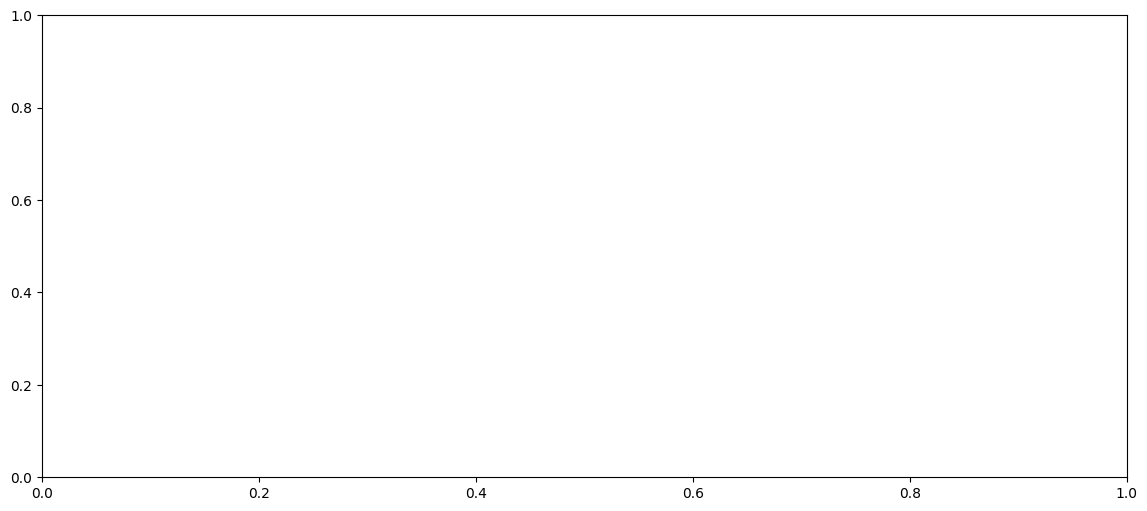

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(monthly_metrics['date'], monthly_metrics['revenue'], label='Revenue', marker='o')
plt.plot(monthly_metrics['date'], monthly_metrics['profit'], label='Profit', marker='o')
plt.title('Revenue and Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


By plotting total revenue and profit from mid-2017 to the end of 2021, we observed a clear and significant upward trend toward the **end of each year** — especially in 2021.  
This suggests strong growth in performance, possibly driven by seasonal demand, successful campaigns, or strategic decisions.

- Revenue and profit both remain relatively stable through 2018–2020.
- Starting in late 2020 and especially in **Q4 of 2021**, both metrics spike significantly.
- This indicates a potential annual pattern where **end-of-year performance outpaces the rest of the year**.


## Amount of Discount over Time

In [ ]:
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
discount_trend = df.groupby('month')['discount'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(data=discount_trend, x='month', y='discount')
plt.title("Average Discount Over Time")
plt.show()


**The sharp increase in both revenue and profit at the end of 2021 appears to correlate directly with a dramatic rise in average discounts during the same period.**

This suggests that the company launched a major discount campaign, most likely as part of an end-of-year strategy.

- The large discounts attracted more buyers or led to larger orders.

- As a result, revenue surged, even if profit margins may have been impacted.



In [ ]:
df['discount'].describe()

Most customers receive moderate discounts — 50% of the data is below 90 $.

However, the mean is much higher (301) due to a few very large discounts (up to 26,948), which indicates skewness.

There might be outliers or bulk/wholesale deals that result in extreme discounts.

## Identifying Relationships Between Numerical Features

In [ ]:

# Generate correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


### Correlation Analysis Summary

The heatmap above visualizes the Pearson correlation coefficients between numerical features in our dataset.

#### Positive Correlations:
- **Revenue**, **Cost**, **Discount**, **Net Revenue**, and **Profit** are all **very highly correlated** with each other (`corr ≈ 0.97–1.00`), suggesting these metrics scale together as expected.
- **Gross Price**, **Fiscal Year**, **Cost Year**, and **Manufacturing Cost** are also tightly correlated (`corr ≈ 0.70`), likely reflecting consistent pricing and production trends over time.
- **Sold Quantity** shows a strong correlation with revenue-related features (`corr ≈ 0.99`), which is logical since more units sold lead to higher revenue.

####  Negative Correlations:
- `pre_invoice_discount_pct` and `profit_margin` have a **strong negative correlation** of **-0.77**, indicating that higher pre-invoice discounts significantly reduce profit margins.
- `customer_code` shows a weak-to-moderate **negative correlation** with `profit_margin` (-0.36).


## Let’s check whether profit margins were impacted during the sales spike in late 2021 due to the large discounts.

In [ ]:

# Calculate average profit margin per month
monthly_margin = df.groupby('month')['profit_margin'].mean().reset_index()
monthly_margin.head()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_margin['month'], monthly_margin['profit_margin'], marker='o', color='orange')
plt.title('Average Monthly Profit Margin Over Time')
plt.xlabel('Month')
plt.ylabel('Profit Margin')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Although the company gave heavier discounts at the end of 2021, it managed to maintain strong profit margins.
This suggests that the increased sales volume likely offset the effect of discounts — leading to higher overall profit.

 ## Which markets and customer types bring the most profit?

In [ ]:
df = df.merge(dim_customer, on='customer_code', how='left')


In [ ]:
# group by region
profit_by_region = df.groupby('region')['profit'].sum().sort_values(ascending=False).reset_index()
profit_by_region

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(data=profit_by_region, x='profit', y='region', palette='Blues_r')
plt.title('Total Profit by Region')
plt.xlabel('Profit')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


The chart and values clearly show that:

- **APAC is the most profitable region**, contributing more than **87 million** in total profit — more than double the next region.
- **EU and NA** are similar in profit (~33M each), showing solid performance.
- **LATAM** stands out as the **least profitable**, contributing less than 1 million in total — which may indicate low sales, limited market presence, or high costs in that region.
 
> This suggests that the company should consider investing more in APAC and possibly reassess its strategy in LATAM.

In [ ]:
# group be market name
profit_by_market = df.groupby('market')['profit'].sum().reset_index()
profit_by_market.sort_values(by='profit')


#### Bottom 5 Least Profitable Markets:
- Columbia, Chile, Mexico, Brazil, and Sweden — each with **less than 350K** in total profit.


- India and the USA are the **clear leaders**, contributing the highest share of total profit.
- Several markets in LATAM (e.g., Colombia, Chile, Mexico) show **very low profit**, which aligns with the previous regional analysis.
- These results highlight where the business is thriving and where there may be **opportunities for growth or restructuring**.

In [ ]:
# group by platform name and channel name
profit_by_platform = df.groupby('platform')['profit'].sum().sort_values(ascending=False).reset_index()
profit_by_channel = df.groupby('channel')['profit'].sum().sort_values(ascending=False).reset_index()
profit_by_platform
 

- **Brick & Mortar** generated more than **double the profit** of **E-Commerce**.
- This may be due to larger bulk orders, lower logistics costs, or stronger partnerships in physical retail channels.


In [ ]:
profit_by_channel

- The **Retailer** channel dominates in terms of profit, contributing over **109 million**, which is nearly **four times more** than the **Direct** channel and **six times more** than **Distributor**.
- This suggests that indirect retail sales are the **most effective model** for AtliQ Hardware, possibly due to high volume, wider customer base, or better pricing efficiency.
- Lower performance of **Distributors** and **Direct** channels may indicate opportunities to reassess contracts, pricing, or customer acquisition strategies.



 ## Which product categories have the highest profit margins?

In [ ]:
df = df.merge(dim_product[['product_code', 'category','product']], on='product_code', how='left')


In [ ]:
df.head()

In [ ]:
df['category'].value_counts()


While reviewing the `category` column from the product data, I discovered that many categories listed in the catalog were not represented in actual sales. For example, categories like `Batteries`, `Gaming Laptop`, and `Processors` had **zero transactions**.

This is likely because the product catalog is broader than the subset of products that were actually sold during the analyzed periTa willken:
Iiltered out all categories that had no transaction records in the sales data to ensure that the analysis focused only on categories that generated revenue or profit.

This cleanup step:
- Removes irrelevant categories from visualizations and calculations.
- Ensures profit margin analysis ibased on **real, acti products**.


In [ ]:
# Removes irrelevant categories from visualizations and calculations.
used_categories = df['category'].value_counts()[df['category'].value_counts() > 0].index
df = df[df['category'].isin(used_categories)]

In [ ]:
# average profit_margin by category

margin_by_category = (
    df[df['profit_margin'].notna()]
    .groupby('category')['profit_margin']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .dropna()
)

# Convert profit_margin to %
margin_by_category['profit_margin'] = round(margin_by_category['profit_margin'] * 100,2)
margin_by_category

In [ ]:
sns.barplot(
    data=margin_by_category,
    x='profit_margin',
    y='category'
)

plt.title('Average Profit Margin by Product Category (%)')
plt.xlabel('Profit Margin (%)')
plt.ylabel('Product Category')
plt.xlim(0, 100) 
plt.tight_layout()
plt.show()

- Both categories demonstrate **very high profit margins** (above 60%), indicating strong pricing power and cost efficiency.
- The **small difference** between them suggests both are reliable profit drivers.
- These insights highlight areas where the company may consider continuing to invest or scale further.

Note: All other categories were excluded due to having zero transactions or no revenue, resulting in undefined or missing profit margin values.

## Most Profitable Products within Top Categories

In [ ]:
top_categories = ['Internal HDD', 'Graphic Card']
filtered_df = df[df['category'].isin(top_categories)]
filtered_df.head()

In [ ]:
product_profit = (
    filtered_df
    .groupby(['category', 'product'])['profit']
    .sum()
    .reset_index()
    .sort_values(by='profit', ascending=False)
)
product_profit.head()

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=product_profit.head(4), x='profit', y='product', hue='category')
plt.title('Top 4 Most Profitable Products in Graphic Card & Internal HDD')
plt.xlabel('Total Profit')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

After identifying **Internal HDD** and **Graphic Card** as the most profitable categories, I analyzed which specific products within these groups generate the highest total profit.
- **3 out of 4 top-performing products** belong to the **Internal HDD** category, confirming its dominant role in profit generation.
- The **AQ Dracula HDD** leads by a significant margin, generating over **57 million in profit**.
- The only representative from **Graphic Cards** is the **AQ Mforce Gen X**, which also performs strongly.

These results support a deeper focus on the Internal HDD product line and suggest that optimizing sales of a few high-performing products can have a major impact on overall profitability.

## Seasonality in sales (monthly trends)

In [ ]:
df['month_'] = df['date'].dt.month
# Grouping and counting average revenue by month
monthly_avg_revenue = (
    df.groupby('month_')['revenue']
    .mean()
    .reset_index()
    .sort_values('month_')
)
monthly_avg_revenue

In [ ]:

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_avg_revenue, x='month_', y='revenue', marker='o')
plt.title('Average Monthly Revenue (Seasonality Analysis)')
plt.xlabel('Month')
plt.ylabel('Average Revenue')
plt.xticks(range(1, 12))
plt.grid(True)
plt.tight_layout()
plt.show()


- **September to December** are consistently the **most profitable months**..
- This seasonal pattern is likely driven by end-of-year business cycles, holiday shopping, or annual procurement spike

Seasonal analysis showד that the **end of the year is the most lucrative period** for AtliQ Hardware.  
This insight is crucial for future planning — such as **inventory stocking**, **marketing campaigns**, or **budget allocation** toward .s.

#  Part 4: Cohort & Retention Analysis
Creating cohorts based on customer acquisition date, visualizing cumulative retention.

## Customer Lifetime Value (LTV) Cohort Analysis

In [ ]:
# Top 10 Customers by Lifetime Value (LTV)
ltv = df.groupby('customer_code')['profit'].sum().reset_index()
ltv.columns = ['customer_code', 'lifetime_value']
ltv.sort_values(by='lifetime_value', ascending=False).head(10)


These insights can help prioritize **high-value clients** for targeted retention and loyalty strategies.


In [ ]:
# Average Customer Lifetime Value (LTV)
average_ltv = df.groupby('customer_code')['profit'].sum().mean()
print("Average LTV:", round(average_ltv, 2))


This means that, on average, each customer generates approximately **194K in profit** over their lifetime.

This benchmark helps put the **Top 10 LTV customers** in perspective and can be used to evaluate the success of future customer acquisition strategies.

In [ ]:
# Cohort-Based Cumulative LTV Calculation
#  Extracted from the `date` column for grouping.
df['order_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
# Find the cohort month (when the customer first appeared)
cohort = df.groupby('customer_code')['order_month'].min().reset_index()
cohort.columns = ['customer_code', 'cohort_month']
df = df.merge(cohort, on='customer_code')


In [ ]:
#  Add months since first order (cohort index)
df['months_since_first'] = ((df['order_month'].dt.year - df['cohort_month'].dt.year) * 12 +
                            (df['order_month'].dt.month - df['cohort_month'].dt.month))


In [ ]:
#Group and calculate cumulative LTV
cohort_ltv = (
    df.groupby(['cohort_month', 'months_since_first'])['profit']
    .sum()
    .groupby(level=0).cumsum()
    .unstack(fill_value=0)
    .astype(float) 
    .round(1)
)
cohort_ltv

In [ ]:
# Defyining the first order month
cohort_months = df.groupby('customer_code')['order_month'].min()
# Count how many customers made their first purchase in each month
cohort_months.dt.to_period('M').value_counts().sort_index()


As we see from the results, the last acquisition of new customers occurred in **October 2019**, with only 12 new clients. This confirms that after that point, the business did not onboard any new clients, and all revenue since then comes from **repeat buyers**.

This pattern could suggest:
- A saturated market
- Decreased marketing efforts
- Or a shift in business strategy towards retention instead of acquisition

In [ ]:
cohort_ltv = cohort_ltv.astype(float)

# Select only the first 12 months of each cohort for better readability and focus
cohort_ltv_trimmed = cohort_ltv.loc[:, :11]

# correct index
cohort_ltv_trimmed.index = cohort_ltv_trimmed.index.strftime('%Y-%m')

# Построим график
plt.figure(figsize=(12, 6))
sns.heatmap(cohort_ltv_trimmed, cmap="YlGnBu", annot=True, fmt='.0f')
plt.title('Cumulative LTV by Cohort (First 12 Months)')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

In [ ]:
# Select only the next 12 months of each cohort for better readability and focus
cohort_ltv_trimmed_1 = cohort_ltv.loc[:, 12:24]

# correct index
cohort_ltv_trimmed_1.index = cohort_ltv_trimmed_1.index.strftime('%Y-%m')

# Построим график
plt.figure(figsize=(12, 6))
sns.heatmap(cohort_ltv_trimmed_1, cmap="YlGnBu", annot=True, fmt='.0f')
plt.title('Cumulative LTV by Cohort (12-24 Months)')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

In [ ]:
# Select the Flast months of each cohort for better readability and focus
cohort_ltv_trimmed_2 = cohort_ltv.loc[:, 24:36]

# correct index
cohort_ltv_trimmed_2.index = cohort_ltv_trimmed_2.index.strftime('%Y-%m')

# Построим график
plt.figure(figsize=(12, 6))
sns.heatmap(cohort_ltv_trimmed_2, cmap="YlGnBu", annot=True, fmt='.0f')
plt.title('Cumulative LTV by Cohort (24-36 Months)')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

In [ ]:
# Choose next 12 montns
cohort_ltv_trimmed_3 = cohort_ltv.loc[:, 36:]

# correct index
cohort_ltv_trimmed_3.index = cohort_ltv_trimmed_3.index.strftime('%Y-%m')

# Построим график
plt.figure(figsize=(20, 6))
sns.heatmap(cohort_ltv_trimmed_3, cmap="YlGnBu", annot=True, fmt='.0f')
plt.title('Cumulative LTV by Cohort (36-51 months)')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

This heatmaps represent the cumulative profit generated by customer cohorts over time.


- The **September 2017 cohort** stands out significantly, showing consistent growth in LTV over 51 months and achieving the **highest cumulative revenue** among all groups.
- All later cohorts (2017-10 to 2019-10) demonstrate **much lower LTV growth**, with many reaching a plateau within 6–12 months.
- Some cells contain `0`, which may indicate:
  - Customers churned early.
  - Data gaps or missing orders.
  - Smaller customer base in those cohorts (confirmed by low cohort size).

### Business Implication:
- The first customer cohort was the **most valuable**, possibly due to:
  - Better initial marketing or onboarding.
  - Stronger product-market fit at launch.
- Subsequent cohorts underperform, suggesting potential issues in **customer retention**, **product updates**, or **targeting strategies**.

> **Recommendation:** Deep-dive into the early cohort strategy to identify success factors and reapply them to improve newer customer engagement and LTV growth.

## Cumulative Retention 

In [ ]:
# Count unique customers per cohort per month
cohort_counts = (
    df.groupby(['cohort_month', 'months_since_first'])['customer_code']
    .nunique()
    .unstack(fill_value=0)
)
cohort_counts

In [ ]:
#  Calculate cumulative retention
cohort_sizes = cohort_counts.iloc[:, 0]  # customers in month 0
cumulative_retention = (cohort_counts.divide(cohort_sizes, axis=0).round(2))*100


cumulative_retention

In [ ]:
# Filter columns (only every 5th month)
filtered_columns = cumulative_retention.columns[::5]
filtered_retention = cumulative_retention[filtered_columns]

# correct index
filtered_retention.index = filtered_retention.index.strftime('%Y-%m')
# Plot the improved heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    filtered_retention , 
    cmap='YlGnBu',
    annot=True,
    fmt=".1f",
    linewidths=0.3,
    linecolor='gray',
    cbar_kws={'label': 'Retention %'}
)

plt.title('Cohort Cumulative Retention (Every 5 Months)', fontsize=14)
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

- **2017-09 cohort** shows consistent retention (over 60%) even after 50 months — indicating highly loyal customers.

- Cohorts after 2019 tend to drop off after the 20th month.

- The 0% values (white blocks) suggest customer inactivity or lack of new cohorts.

## Cohort Analysis — Discount Dynamics Over Time

In [ ]:
#  Group and calculate the average discount per cohort and month since first purchase
discount_by_cohort = (
    df.groupby(['cohort_month', 'months_since_first'])['discount']
    .mean()
    .unstack(fill_value=0)
)

# Ensure values are float type (in case of any formatting issues)
discount_by_cohort = discount_by_cohort.astype(float)

# Filter columns (only every 5th month)
filtered_columns = discount_by_cohort.columns[::5]
filtered_retention = discount_by_cohort[filtered_columns]

# Format cohort index for better readability
cohort_index = discount_by_cohort.index.strftime('%Y-%m') 
filtered_retention.index = cohort_index

# PLOT
plt.figure(figsize=(14, 6))
sns.heatmap(filtered_retention, cmap='YlOrBr', annot=True, fmt='.0f')
plt.title('Average Discount by Cohort and Months Since First Purchase (Every 5 Months)')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()


Average Discount by Cohort and Months Since First Purchase) represent the average discount amount given to customers from each cohort during specific months since their first purchase. A value of **0** means that **no discount** was applied in that cohort-month combination.

### Discounts and Their Influence on Customer Retention

By comparing the **Average Discount Heatmap** with the **Cumulative Retention Heatmap**, I  observe a noticeable pattern:

- Periods where **no discounts (0 value)** were offered **often coincide** with sharp drops in customer retention.
- For example, many cohorts show **zero retention** in the same months where **no discount** was provided.
- In contrast, months with **increased discounts** (e.g., months 25, 50) correspond to **higher retention** or at least extended customer activitivity.


**Lack of discounts appears to be a strong contributor to customer drop-off. Introducing targeted discounts during key lifecycle months (e.g., 5, 10, 25, 50) may help **retain more customers** and extend their lifetime value (LTV).**

### Recommendation:
- **Implement strategic discount campaigns** at critical points in the customer journey.
- **Test and monitor** the effectiveness of discounts on retention over time using cohort analysis.


#  Part 5: Lifetime Value (LTV) Modeling 

**My goal is to build a machine learning regression model that predicts the Customer Lifetime Value (LTV) based on early behavioral data.**

In [ ]:
#Get the first purchase date for each customer
df['first_order_date'] = df.groupby('customer_code')['date'].transform('min')
#Calculate days since first purchase
df['days_since_first_order'] = (df['date'] - df['first_order_date']).dt.days
# Filter only first 30 days of activity
first_30_df = df[df['days_since_first_order'] <= 30]

In [ ]:
# Aggregate features per customer
features_df = first_30_df.groupby('customer_code').agg({
    'sold_quantity': 'sum',            # total orders
    'revenue': 'sum',                  # revenue
    'profit': 'sum',                   # profit
    'discount': ['mean', 'sum'],  # discount 
    'region': 'first',                 # customer segment info
    'channel': 'first'
}).reset_index()

# Rename columns
features_df.columns = ['customer_code', 'total_orders_30d', 'revenue_30d', 'profit_30d',
                       'avg_discount_30d', 'total_discount_30d', 'region', 'channel']
features_df

In [ ]:
#target variable: total lifetime profit (LTV)
ltv = df.groupby('customer_code')['profit'].sum().reset_index()
ltv.columns = ['customer_code', 'ltv']
ltv

In [ ]:
#Merge features and target
ml_df = features_df.merge(ltv, on='customer_code')
ml_df.head()


In [ ]:
# Separate features and target
features = ml_df.drop(columns=['customer_code', 'ltv'])
target = ml_df['ltv']

In [ ]:
# Split into train (60%), validation (20%), test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(features, target, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=123) 

In [ ]:
#Define preprocessing
numeric_features = ['total_orders_30d', 'revenue_30d', 'profit_30d', 'avg_discount_30d', 'total_discount_30d']
categorical_features = ['region', 'channel']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop=None, handle_unknown='ignore'), categorical_features)
])

In [ ]:
#Random Forest
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=123))
])

#Train the model
model.fit(X_train, y_train)

#Predict on validation set
y_pred = model.predict(X_val)

#Evaluate the model
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

(mae, rmse, r2)

**Random Forest Regressor**

- MAE (Mean Absolute Error): ~52,133
  → On average, the model is off by about 54K when predicting a customer's LTV.

- RMSE (Root Mean Squared Error): ~73,354
  → This value is a bit higher, showing that some errors are larger than others — 
    RMSE is more sensitive to outliers.

- R² Score: ~0.77
  → This means our model explains about 78% of the variation in LTV. 
    It’s a strong score, but there’s still some unexplained variance.


In [ ]:
# Create pipeline with Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit model on training set
lr_pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred_lr = lr_pipeline.predict(X_val)

# Evaluate model performance
mae_lr = mean_absolute_error(y_val, y_pred_lr)
rmse_lr = mean_squared_error(y_val, y_pred_lr, squared=False)
r2_lr = r2_score(y_val, y_pred_lr)

(mae_lr, rmse_lr, r2_lr)

 **Linear Regression**

- **MAE (Mean Absolute Error): ~50,323**  
  → On average, the model’s predictions are off by about **50K** when estimating customer LTV — slightly better than the Random Forest.

- **RMSE (Root Mean Squared Error): ~60,016**  
  → This is lower than the Random Forest's RMSE, suggesting that **this model has fewer large errors** and is more consistent overall.

- **R² Score: ~0.86**  
  → This means the model explains **about 86% of the variance in LTV**, making it a **highly reliable and interpretable model**.

> **Conclusion**: Linear Regression performed slightly better than Random Forest in this case, providing both high accuracy and easy-to-interpret feature importance.

# Part 7:  Final Business Analysis Summary & Strategic Recommendations
______________________________________________________________________
As part of a comprehensive financial analysis for AtliQ Hardware, I explored transactional, regional, product-level, customer-level, and cohort-based dimensions using 67,250 real sales records.

- The business maintains **strong average profit margins** (~60.9%) and achieves high-value transactions, with top deals exceeding 95,000 in revenue.
- However, the distribution is **highly skewed**, with many small-value transactions and a few large deals pulling up the mean.
- Revenue and profit show a **seasonal surge toward the end of each fiscal year**, especially in Q4 — highlighting the importance of year-end performance planning.

## Discounts as a Growth Lever

- A significant spike in **average discount size** at the end of 2021 directly correlates with the largest profit and revenue increase across the dataset.
- **Correlation analysis confirms** a strong negative correlation between discount percentage and profit margin (≈ -0.77).
- Despite lower per-unit margins, volume-based growth **offset the impact of discounting**, leading to overall higher profit.

> **Insight**: Strategic discounting is not only effective — it is crucial for driving top-line growth when used seasonally or for targeted campaigns.

##  Regional & Channel Profitability

- **APAC** is by far the **most profitable region** (87M+), while **LATAM severely underperforms** (<1M), signaling opportunity for market exit or strategic reevaluation.
- **India and the USA** are the most lucrative individual markets.
- **Brick & Mortar outperforms E-Commerce** by a wide margin, and the **Retailer** channel contributes ~4x more profit than Direct or Distributor sales.

> **Recommendation**: Focus investment and marketing in APAC, Brick & Mortar, and Retailer-based channels; re-evaluate LATAM and Direct/Distributor contracts.

## Product Portfolio Analysis

- Many catalog products (e.g., Batteries, Gaming Laptops) showed **zero sales**.
- We filtered these from the analysis to focus on real, revenue-generating items.
- The most profitable categories are **Internal HDD** and **Graphic Cards**, with the **AQ Dracula HDD** generating over **57M profit alone**.

> **Recommendation**: Concentrate resources on best-performing SKUs and phase out or review underperforming categories.

## Seasonality & Retention

- **September–December consistently drive the highest profits**, emphasizing the importance of Q4 inventory and budget alignment.
- Retention cohort analysis revealed:
  - The **2017-09 cohort** has outstanding LTV and retention (up to 60% after 50 months).
  - All cohorts post-2019 show sharp drop-offs in retention and LTV.
  - No new customer acquisitions after **October 2019**, signaling a critical shift in business dynamics.

## Behavioral Drivers Behind Retention

- Retention heatmaps show that **customer activity collapses in months where no discounts are offered**.
- Discounts not only drive immediate revenue but appear to **prolong customer lifecycle**.

> **Recommendation**:
- **Reintroduce structured discount programs** in months 5, 10, 25, 50 of customer lifecycle.
- Use retention-linked discounting to prevent churn and support LTV extension.
